# 3. Association rule learning

In [1]:
import sys
from collections import defaultdict
import random

In [47]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def tidlists(transactions):
    tl = defaultdict(set)
    for tid, t in enumerate(transactions): 
        for item in t:
            tl[item].add(tid) 
    return list(tl.items())

class IntersectAll:
    def __and__(self, other): 
        return other
IntersectAll = IntersectAll()

In [5]:
def eclat(items, minsup=0, minlen=1): 
    frequent_itemsets = {(): IntersectAll} 
    def recurse(items, prefix):
        while len(items) > 0:
            item, item_tidlist = items.pop()
            l = prefix + (item,) # l is the (ordered) tuple of items we are Looking for 
            new_tidlist = frequent_itemsets[prefix]& item_tidlist
            if len(new_tidlist) >= minsup: # add frequent_itemsets to the new frequent_itemsets 
                frequent_itemsets[l] = new_tidlist
                
                # define the new l-conditional database 
                new_items = []
                for new_item, _item_tidlist in items: 
                    new_item_tidlist = _item_tidlist & item_tidlist 
                    if len(new_item_tidlist) >= minsup:
                        new_items.append((new_item,new_item_tidlist))
                        
                # recurse, with l as prefix 
                recurse(new_items, l)
                
    recurse(items.copy(), ())
    return {k: len(v) for k, v in frequent_itemsets.items() if len(k) >= minlen}

### Đọc dữ liệu, chuẩn hóa dữ liệu

In [56]:
data = pd.read_csv('Data/market_basket.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [9]:
data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [57]:
df = data.drop(['Unnamed: 0'], axis=1)

In [64]:
df.head(20)

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
5,02/01/2016,5010,6,JPI,GVBRC,1.0,10.77
6,02/01/2016,1666,7,XG4,AHAE7,1.0,3.65
7,02/01/2016,1666,7,FEW,AHZNS,1.0,8.21
8,02/01/2016,1253,8,0H2,9STQJ,1.0,8.25
9,02/01/2016,5541,9,N5F,7IE9S,1.0,8.18


In [59]:
# display variable names and data types
df.dtypes

Date               object
Customer_ID         int64
Transaction_ID      int64
SKU_Category       object
SKU                object
Quantity          float64
Sales_Amount      float64
dtype: object

In [62]:
for col in ['Customer_ID','Transaction_ID']:
    df[col] = df[col].astype('object')

df.dtypes

Date                object
Customer_ID         object
Transaction_ID      object
SKU_Category      category
SKU               category
Quantity           float64
Sales_Amount       float64
dtype: object

In [63]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,131706,363,23/09/2016,638,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_ID,131706.0,22625.0,1660.0,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transaction_ID,131706.0,64682.0,1348.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SKU_Category,131706,187,N8U,10913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SKU,131706,5242,UNJKW,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,131706.0,NaN,NaN,NaN,1.485311,3.872667,0.01,1.0,1.0,1.0,400.0
Sales_Amount,131706.0,NaN,NaN,NaN,11.981524,19.359699,0.02,4.23,6.92,12.33,707.73


Nhận xét:
- Có một nhóm khách hàng thường xuyên mua sắm, trong khi có rất nhiều khách hàng mua sắm ít thường xuyên, rất nhiều chỉ mua một lần (1/4).
- Có tổng cộng 5,242 sản phẩm (SKU) khác nhau trong dữ liệu, tần suất xuất hiện biến đổi mạnh, một số sản phẩm bán được nhiều lần và một số sản phẩm ít được bán.

In [23]:
# create series counting the number of unique items in a transaction
TransCount = df.groupby(['Transaction_ID'])['SKU'].count().sort_values(ascending=True)

In [24]:
# create dictionary to store unique items per transaction
dict_transCount = {}

In [26]:
# assign unique item counts to dictionary
for i in TransCount.unique():
    dict_transCount[i] = 0
    
# count number of transactions with same unique item counts to dictionary
for j in TransCount:
    dict_transCount[j] = dict_transCount[j] + 1

In [27]:
# display dictionary values
dict_transCount

{1: 32906,
 2: 16845,
 3: 6802,
 4: 3478,
 5: 1851,
 6: 1036,
 7: 646,
 8: 426,
 9: 254,
 10: 167,
 11: 94,
 12: 64,
 13: 52,
 14: 23,
 15: 16,
 16: 4,
 17: 6,
 18: 4,
 19: 5,
 20: 1,
 21: 2}

In [13]:
dataset = df.groupby('Customer_ID')['Transaction_ID'].apply(list)

In [15]:
dataset

Customer_ID
1                                             [3442, 3442]
2                                           [14177, 30451]
3                                             [90, 90, 90]
4                      [34042, 54618, 54618, 54618, 54618]
5                        [6370, 8624, 14133, 26651, 33043]
                               ...                        
22621                                       [60552, 60552]
22622                                              [62034]
22623                                       [63025, 63025]
22624                                       [58791, 58791]
22625    [59000, 59000, 59000, 59000, 61419, 61419, 614...
Name: Transaction_ID, Length: 22625, dtype: object

In [65]:
# generate groups by SKU and sum the quantity sold
dfilter = df.groupby(['SKU'])['Quantity'].sum().reset_index(name='Quantity')

# filter by quantity of sales greater than 10
dfilter = dfilter[dfilter['Quantity'] > 10]

# display report
dfilter

,SKU,Quantity
1,00OK1,18.0
2,0121I,31.0
3,01IEO,43.0
6,01V7M,45.0
9,03C6L,36.0
...,...,...
5230,ZVTO4,236.0
5231,ZWFSY,862.0
5233,ZWWB5,11.0
5236,ZYF2U,14.0


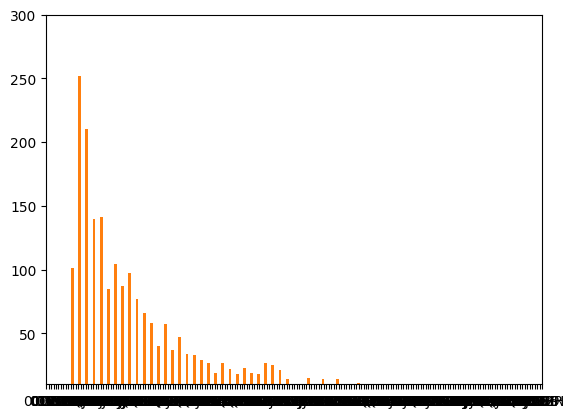

In [66]:
# plot dataset
fig, ax = plt.subplots()

ax.hist(dfilter, bins=2000, linewidth=0.1)

ax.set(xlim=(0,200),
      ylim=(10,300))

plt.show()

In [ ]:
# one hot encode SKU's
basket = (df.groupby(['Customer_ID', 'SKU'])['Quantity']
         .sum().unstack().reset_index().fillna(0)
         .set_index('Customer_ID'))

# display dataframe
basket

In [12]:
tl = tidlists(dataset)
tl[0][0]

'yogurt'

In [13]:
len(tl)

38

In [14]:
for i in range(len(tl)-1):
    if tl[i][0] == 'nan':
        print(i) 
        del tl[i]

In [15]:
result = eclat(tl, minsup=60, minlen=3)

In [16]:
from collections import OrderedDict
d_sorted_by_value = OrderedDict(sorted(result.items(), key=lambda x : x[1]))
type(d_sorted_by_value)

collections.OrderedDict

In [17]:
sorted_d = sorted((value, key) for (key,value) in result.items()) 
sorted_d[:10]

[(60, ('aluminum foil', 'beef', 'vegetables', 'all- purpose')),
 (60, ('aluminum foil', 'butter', 'pork')),
 (60, ('aluminum foil', 'vegetables', 'butter', 'soda')),
 (60, ('aluminum foil', 'vegetables', 'flour', 'sandwich bags')),
 (60, ('aluminum foil', 'vegetables', 'soda', 'pork')),
 (60, ('bagels', 'cereals', 'vegetables', 'all- purpose')),
 (60, ('bagels', 'cheeses', 'vegetables', 'all- purpose')),
 (60, ('bagels', 'hand soap', 'aluminum foil', 'vegetables')),
 (60, ('bagels', 'hand soap', 'butter')),
 (60, ('bagels', 'ketchup', 'spaghetti sauce', 'vegetables'))]

In [18]:
sorted_d[-10:]

[(175, ('eggs', 'dishwashing liquid/detergent', 'vegetables')),
 (177, ('eggs', 'poultry', 'vegetables')),
 (178, ('eggs', 'dinner rolls', 'vegetables')),
 (178, ('poultry', 'mixes', 'vegetables')),
 (179, ('eggs', 'vegetables', 'yogurt')),
 (179, ('waffles', 'vegetables', 'lunch meat')),
 (180, ('eggs', 'vegetables', 'soda')),
 (180, ('poultry', 'vegetables', 'lunch meat')),
 (182, ('poultry', 'dishwashing liquid/detergent', 'vegetables')),
 (184, ('poultry', 'dinner rolls', 'vegetables'))]

In [19]:
# Truc quan hoa ket qua theo result vua tim ra ???

In [20]:
df_frequent_itemsets = pd.DataFrame(result.items(), columns=['Itemset', 'Support'])
df_frequent_itemsets = df_frequent_itemsets.sort_values(by='Support', ascending=False)
df_frequent_itemsets

,Itemset,Support
8023,"(poultry, dinner rolls, vegetables)",184
7695,"(poultry, dishwashing liquid/detergent, vegeta...",182
6569,"(eggs, vegetables, soda)",180
8096,"(poultry, vegetables, lunch meat)",180
6594,"(eggs, vegetables, yogurt)",179
...,...,...
5696,"(juice, beef, vegetables, all- purpose)",60
6895,"(bagels, cereals, vegetables, all- purpose)",60
5697,"(juice, beef, vegetables, lunch meat)",60
640,"(sugar, individual meals, dinner rolls, vegeta...",60


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

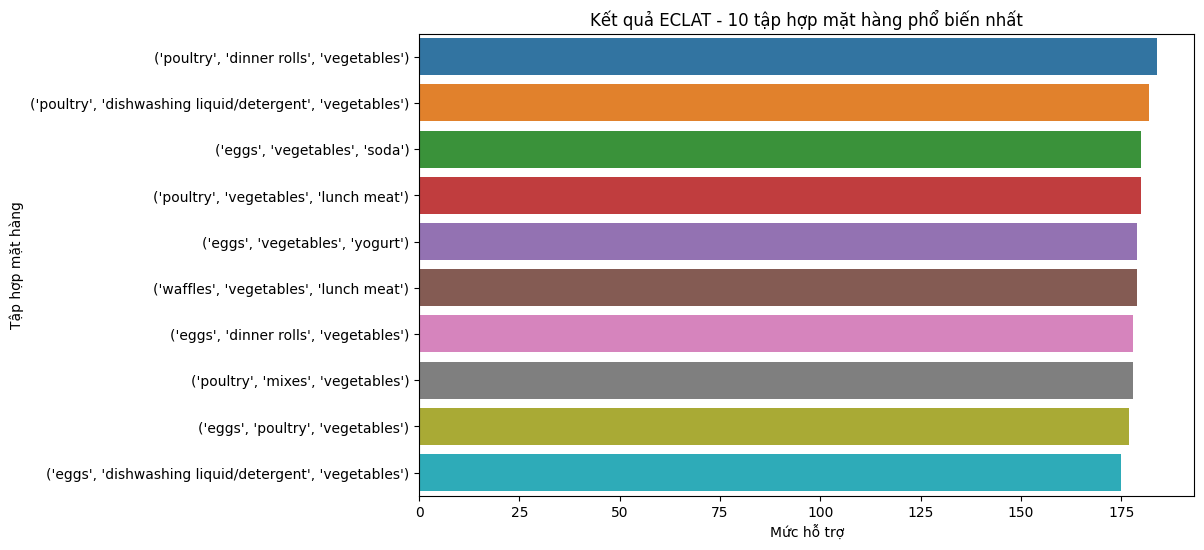

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Support', y='Itemset', data=df_frequent_itemsets.head(10))
plt.xlabel('Mức hỗ trợ')
plt.ylabel('Tập hợp mặt hàng')
plt.title('Kết quả ECLAT - 10 tập hợp mặt hàng phổ biến nhất')
plt.show()

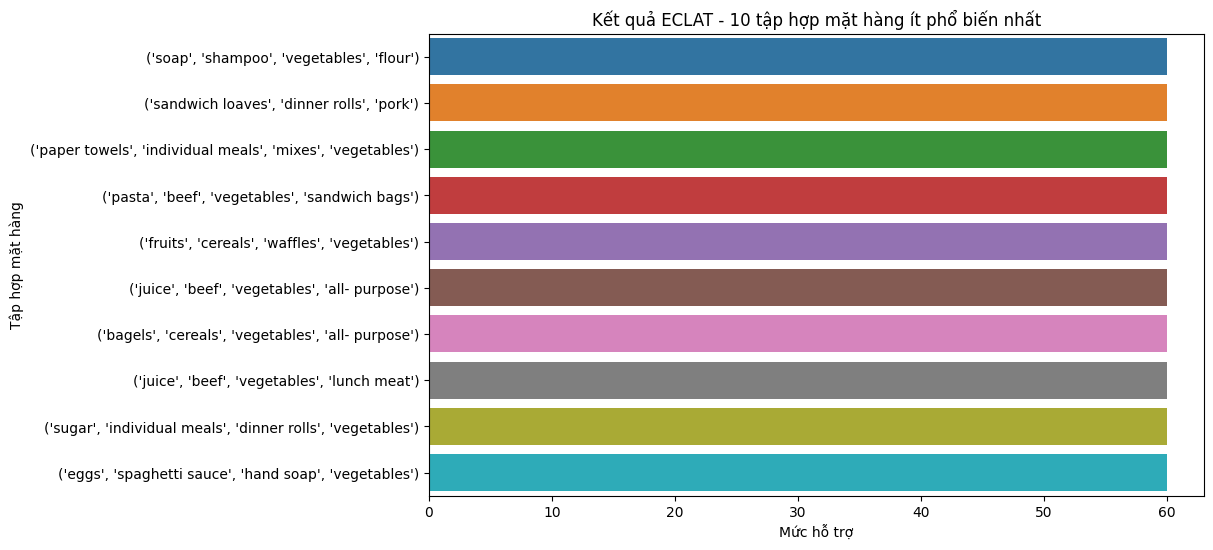

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Support', y='Itemset', data=df_frequent_itemsets.tail(10))
plt.xlabel('Mức hỗ trợ')
plt.ylabel('Tập hợp mặt hàng')
plt.title('Kết quả ECLAT - 10 tập hợp mặt hàng ít phổ biến nhất')
plt.show()

In [24]:
# "Có eggs không? nó kết hợp với item nào?"
for k, v in result.items():
    if "eggs" in k: 
        print(k, ":", v)

('sugar', 'fruits', 'eggs') : 69
('sugar', 'coffee/tea', 'eggs') : 73
('sugar', 'coffee/tea', 'eggs', 'vegetables') : 62
('sugar', 'paper towels', 'eggs') : 76
('sugar', 'paper towels', 'eggs', 'vegetables') : 66
('sugar', 'pasta', 'eggs') : 79
('sugar', 'pasta', 'eggs', 'vegetables') : 67
('sugar', 'juice', 'eggs') : 72
('sugar', 'juice', 'eggs', 'vegetables') : 63
('sugar', 'eggs', 'bagels') : 72
('sugar', 'eggs', 'bagels', 'vegetables') : 62
('sugar', 'eggs', 'poultry') : 94
('sugar', 'eggs', 'poultry', 'vegetables') : 82
('sugar', 'eggs', 'sandwich loaves') : 60
('sugar', 'eggs', 'ketchup') : 77
('sugar', 'eggs', 'ketchup', 'vegetables') : 65
('sugar', 'eggs', 'spaghetti sauce') : 72
('sugar', 'eggs', 'spaghetti sauce', 'vegetables') : 63
('sugar', 'eggs', 'tortillas') : 72
('sugar', 'eggs', 'tortillas', 'vegetables') : 64
('sugar', 'eggs', 'cereals') : 81
('sugar', 'eggs', 'cereals', 'vegetables') : 71
('sugar', 'eggs', 'individual meals') : 71
('sugar', 'eggs', 'individual meals'

In [25]:
# 10 san pham ma cua hang ban nhieu nhat/it nhat (theo tl)

In [26]:
def find__individual_products_sold(transactions):
    product_counts = defaultdict(int)
    
    for transaction in transactions:
        for product in transaction:
            product_counts[product] += 1
    
    sorted_products = sorted(product_counts.items(), key=lambda x: x[1], reverse=True)
    sold_product_df = pd.DataFrame(sorted_products, columns=['Product', 'Count'])
    return sold_product_df

In [27]:
sold_product_df = find__individual_products_sold(dataset)

In [28]:
print("10 sản phẩm cửa hàng bán nhiều nhất:")
print(sold_product_df.head(10))

10 sản phẩm cửa hàng bán nhiều nhất:
      Product  Count
0  vegetables   1702
1     poultry    640
2        soda    597
3     cereals    591
4   ice cream    579
5     cheeses    578
6     waffles    575
7        soap    574
8  lunch meat    573
9      bagels    573


In [29]:
print("10 sản phẩm cửa hàng bán ít nhất:")
print(sold_product_df.tail(10))

10 sản phẩm cửa hàng bán ít nhất:
              Product  Count
28          tortillas    543
29  laundry detergent    542
30              pasta    542
31      sandwich bags    536
32    spaghetti sauce    536
33              sugar    533
34               pork    531
35             fruits    529
36    sandwich loaves    523
37          hand soap    502
